# Predicting Strokes

The following code have the intends to answer some questions about the possibility of getting a stroke based on a series of features/variables that we expect can enlight the hypothesis drawn from the questions. 

This hypothesis made no need any AI approach in order to get an answer, and maybe coiuld be answer with another statitics method or with a simply data exploration.

I am using the dataset extracted from Kaggle:

https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

## Questions

1. Is gender a predisposing factor for a stroke?
2. Do people who have higher glucose more predisposed to have a stroke?
3. Can we predict a stroke based on this variables?



In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import scipy

In [2]:
data = pd.read_csv('./data_files/healthcare-dataset-stroke-data.csv')
print(data.shape)
data.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

The first thing we need to check is form presence of missing values. 

In [4]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
percentage_bmi_missing = data['bmi'].isnull().sum()/data.shape[0]
print(f'The % of bmi values missing is {percentage_bmi_missing} ')

The % of bmi values missing is 0.03933463796477495 


This dataset seems to be mostly complete the only colum that seems to have missing values is bmi, almost 4% of missing data, for this amount we can try to use the median and not bias the model. However lets see how much of the represent the portion of gender and see id equaly 

In [6]:
data[pd.isna(data['bmi'])].groupby(['gender']).count()

,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,,
Female,97,97,97,97,97,97,97,97,0,97,97
Male,104,104,104,104,104,104,104,104,0,104,104


we can see they are fairly distribute by gender so we can input the values using the mean

In [7]:
data['bmi']=data['bmi'].apply(lambda value: data['bmi'].mean() if pd.isnull(value) else value )

Now we have deal with the missing the values, let move ahead to the next steps 

## Is gender a predisposing factor for a stroke?

### Part I

Lets tackle this from a simpler visualization that a allow us to explore this and then move to a more statistical correspondant to answer that. Using an anova

In [8]:
data.groupby('gender')['stroke'].count()

gender
Female    2994
Male      2115
Other        1
Name: stroke, dtype: int64

First we can see that third group other only have one observation which is not usefull to generate any insight

gender
Female    0.047094
Male      0.051064
Other     0.000000
Name: stroke, dtype: float64


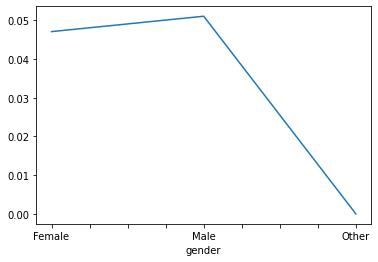

In [9]:
print(data.groupby('gender')['stroke'].mean())
data.groupby('gender')['stroke'].mean().plot();

We can see from the previous information that it seems to be an increase of strokes on Males than Females but in order to back up this, let's see if the difference is significant. Since Scikit learn doesn't have a direct way to calculate an anova lets use scipy and statmodels in order to calculate it 

In [10]:
from scipy.stats import f_oneway
f_oneway(data[data['gender']=='Male']['stroke'],data[data['gender']=='Female']['stroke'])

F_onewayResult(statistic=0.42114415376728614, pvalue=0.5163958663809363)

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('stroke ~ gender',data=data).fit()
table = sm.stats.anova_lm(model, typ=1)
print(table)

              df      sum_sq   mean_sq         F   PR(>F)
gender       2.0    0.021906  0.010953  0.236176  0.78965
Residual  5107.0  236.844826  0.046377       NaN      NaN


As we can see there is not significant difference between the group, however this might happen for multiple reasons, but as purpose of this post we can say that there is a difference were males seems to have more stroke than females, but we can stand that the difference is significant in order to start taking decision about that, further investigations should be done.


### Part II

How ever lets see in the smoling variable what we get 

In [16]:
data.groupby('smoking_status')['stroke'].count()

smoking_status
Unknown            1544
formerly smoked     885
never smoked       1892
smokes              789
Name: stroke, dtype: int64

smoking_status
Unknown            0.030440
formerly smoked    0.079096
never smoked       0.047569
smokes             0.053232
Name: stroke, dtype: float64


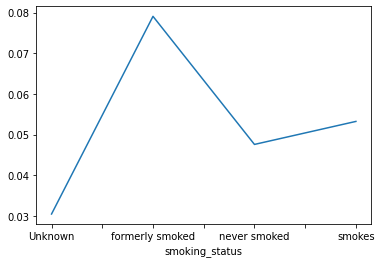

In [20]:
print(data.groupby('smoking_status')['stroke'].mean())
data.groupby('smoking_status')['stroke'].mean().plot();

At this point Unknown act as a missing variable and in this case it is difficult to input these values. What we can do is extract them from the analysis and see if with the data remaining we can draw some insights. However for the later part for predicting stroke we would leave it as 4 category 

In [18]:
data_no_unknown = data[data['smoking_status']!='Unknown']

smoking_status
formerly smoked    0.079096
never smoked       0.047569
smokes             0.053232
Name: stroke, dtype: float64


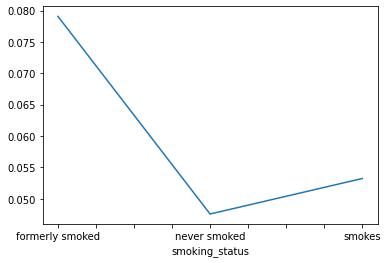

In [21]:
print(data_no_unknown.groupby('smoking_status')['stroke'].mean())
data_no_unknown.groupby('smoking_status')['stroke'].mean().plot();

From that we can see that there is a low difference between the groups, never smoked and smokes are very similar but those differ from the formerly smoked. Which might seems odd, but we could hypothesis it's because people who smokes have dilated blood vessels which can help not getting a stroke right away (see  for more information), but the formely smoked when the stop smoking they lost this quality which returns the blood vessels to a more normal state and this reverse effect with sum of another factor as obesity make this people more vulnerable to have a stroke.

Is important that even it's a low percentage in health issues this can have a big impact, so for this question we can say that smoking and specially formerly smoked have are more prone to have a stroke.

In [33]:
data_no_unknown[data_no_unknown['stroke'] == 0].groupby('smoking_status').count()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke
smoking_status,,,,,,,,,,,
formerly smoked,815,815,815,815,815,815,815,815,815,815,815
never smoked,1802,1802,1802,1802,1802,1802,1802,1802,1802,1802,1802
smokes,747,747,747,747,747,747,747,747,747,747,747


In [34]:
data_no_unknown[data_no_unknown['stroke'] == 1].groupby('smoking_status').count()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke
smoking_status,,,,,,,,,,,
formerly smoked,70,70,70,70,70,70,70,70,70,70,70
never smoked,90,90,90,90,90,90,90,90,90,90,90
smokes,42,42,42,42,42,42,42,42,42,42,42
